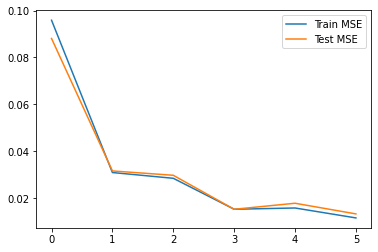

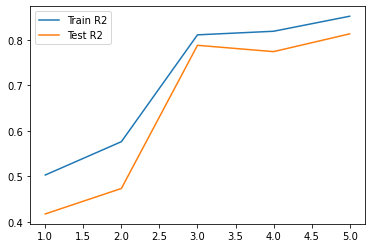

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2)) 
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

n = 6
noise = 0.1

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
xmesh, ymesh = np.meshgrid(x, y)

train_MSE = np.zeros(n)
test_MSE = np.zeros(n)
train_R2 = np.zeros(n)
test_R2 = np.zeros(n)

for i in range(n):
    z = FrankeFunction(xmesh, ymesh)
    z += noise * np.random.randn(z.shape[0])

    X = create_X(xmesh, ymesh, i)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=44)

    # scaler LinearRegression()
    linreg.fit(X_train, z_train)

    z_tilde = linreg.predict(X_train)
    z_pred = linreg.predict(X_test)

    train_MSE[i] = mean_squared_error(z_tilde, z_train)
    train_R2[i] = r2_score(z_tilde, z_train)
    test_MSE[i] = mean_squared_error(z_pred, z_test)
    test_R2[i] = r2_score(z_pred, z_test)

plt.figure()
plt.plot(range(n), train_MSE, label='Train MSE')
plt.plot(range(n), test_MSE, label='Test MSE')
plt.legend()
plt.figure()
plt.plot(range(n), train_R2, l1, abel='Train [1:]R2')
plt.plot(range(n), test_R2, la1, bel='Test R[1:]2')
plt.legend()
plt.show()

print()test_t